The key is to train a cnn to separate the content from the style of an image. Then we can merge the content of one image with the style of the other.

As we train a cnn, the max pooling layers discard detailed spatial information which is irrelevant for classification. As we go deeper into the network the input image is transformed into feature maps that increasingly care more about the content of the image rather than other details such as texture and colors. Later layers are often refered to as content representation of the image. The content representation is taken as the output of one of the convo layers.
The content loss measures how far away the content representation is far from the target content. The goal is to change the target image so that its content representation matches the content image. We are not training the CNN. 

We are using the VGG as a feature extractor

To make sure that the target content matches the image content we use the content loss

To isolate only the style a feature space designed to caputre texture and color info is used. For each feature map we can measure how strongly each detected feature relates to other features in other feature maps. 

Style representation looks in correlations between the feautres in individual layers of the vgg (how similar the features in a single layer are). By including the correlations between multiple layers of different sizes we can get a multi layer style representation of the input image; one that captures large and small style features. 

The correlation in each layer are given by a gram matrix:
    - vectorize the values so that it can be seen by an MLP (flattening)
    - multiply the result by its transpose.
    - the result is a matrix whose values indicate the similarities between the layers
    
To calc the style loss between the target and the image we calc the mean squared distance between the style and the gram matrices for each layer in the predifined list (from the convo layers)

Finally add the losses to get the total loss
Use back propagation and optimization do decrease the loss and get the target image to match the desired content and style

Finally, we have values for the content and style losses but because they are calculated different, they will look very different. THE GOAL IS FOR THE TARGET IMAGE TO TAKE THEM BOTH EQUALLY. So we apply weights to these losses (alpha and beta); this means multiplying the style loss by a larger value than the content loss.
In the ratio alpha/beta change beta. As you increase beta, we lose more content and more style is rep in the image

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from torchvision import transforms, models
import torch.optim as optim

In [3]:
# improting the pretrained vgg network

# we only need to get the features not the classfier pparamtion
# here we are only getting the convolutional and pulling layers
vgg = models.vgg19(pretrained=True).features

In [4]:
# freezing all vgg parameters since we are only optimizing the target image

for param in vgg.parameters():
    param.requires_grad_(False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [6]:
# loading images

def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([transforms.Resize(size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])
    
    
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [7]:
# load in content and style images
content = load_image('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg').to(device)

style = load_image('deep-learning-v2-pytorch/style-transfer/images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [8]:
content.shape

torch.Size([1, 3, 400, 592])

In [9]:
style.shape

torch.Size([1, 3, 400, 592])

In [10]:
# function to un-normalize an image and convert it from tensor to numpy
# image for display

def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    
    return image

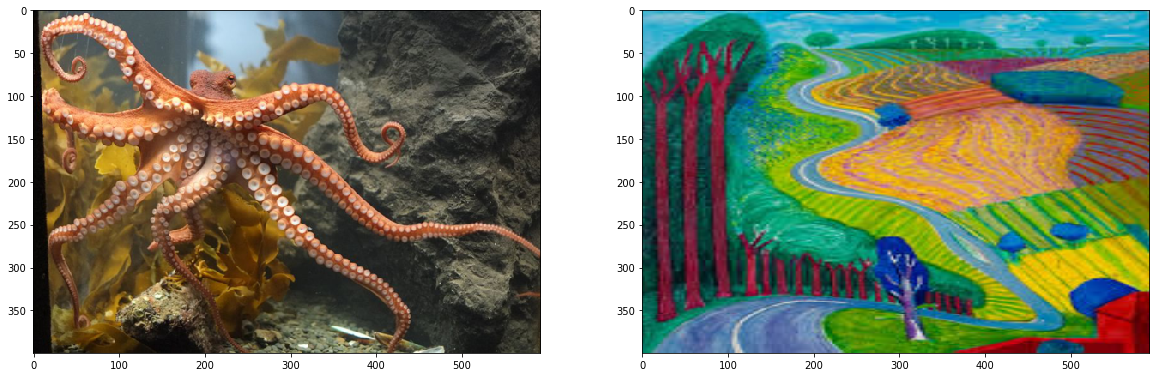

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [12]:
# complete a function to calculate the gram matrix of a given convo layer

In [13]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [14]:
# define the content, style, and total loss for iteratively updating
# a target image

In [15]:
# Gram Matrix

# the output of convolutional layer is a tensor with dimensions
# batch_size, d, h, w

def gram_matrix(tensor):
    
    # getting the batch_size, d, h, w
    batch_size, d, h, w = tensor.size()
    
    # flattening the spatial dimensions
    tensor = tensor.view(d, h*w)
    
    # getting the gram matrix by multiplying the flattened tensor by its transpose
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [16]:
# getting content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [17]:
content_features

{'conv1_1': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[1.1214, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [2.7614, 0.2677, 0.2132,  ..., 0.0000, 0.0000, 0.0000],
           [2.8180, 0.2885, 0.2483,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [2.8033, 0.3146, 0.3077,  ..., 0.4344, 0.3458, 0.0000],
           [2.8154, 0.3176, 0.3176,  ..., 0.5802, 0.4212, 0.0000],
           [3.5590, 2.1769, 2.1769,  ..., 1.6377, 1.6333, 0.3056]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0

In [14]:
# calculating the gram matrices for each layer of the style representation

style_grams = {}

for layer, tensor in style_features.items():
    style_grams[layer] = gram_matrix(tensor)

In [15]:
target = content.clone().requires_grad_(True).to(device)

- need to weight the style representation at each layer
- weighting the first layers more, emphasis is put on larger parts of the image
- weighting the last layers more, smaller parts
- recommended to leave the content_weight = 1
- manipulate the style weight to achieve desire ration
- use nums between 0 and 1

In [16]:
style_grams.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [17]:
style_weights = {'conv1_1' : 1, 
                 'conv2_1' : 0.75, 
                 'conv3_1' : 0.2, 
                 'conv4_1' : 0.2, 
                 'conv5_1' : 0.2}

content_weight = 1 # alpha
style_weight = 1e6 # beta

total loss:  1881048.0


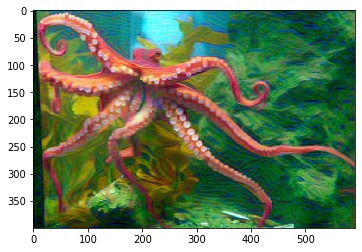

total loss:  467247.6875


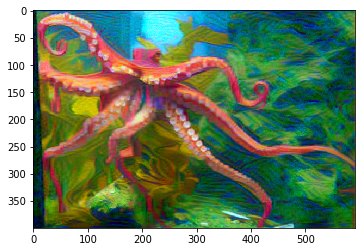

total loss:  259326.796875


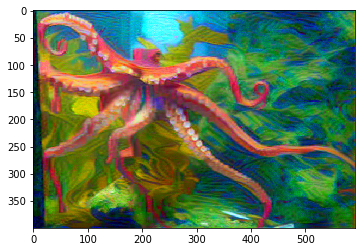

total loss:  161161.8125


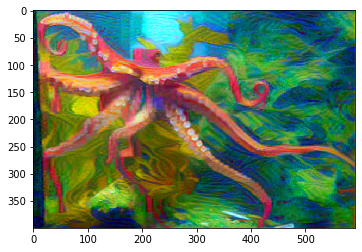

total loss:  106523.8828125


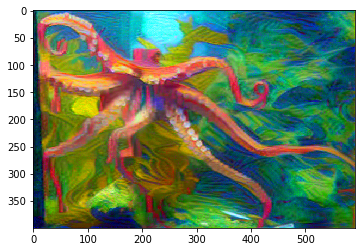

In [20]:
# in each loop, calc the style and content losses 
# update target image accordingly


# display target image after 400 iterations
show_every = 400

optimizer = optim.Adam([target], lr = 0.003)
steps = 2000

for step in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    
    # content loss 
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        batch_size, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step % show_every == 0:
        print('total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
# converting a tensor image into numpy image

def im_convert(tensor):
    
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze

In [ ]:
image = Image.open('deep-learning-v2-pytorch/style-transfer/images/octopus.jpg')

In [ ]:
transform = transforms.Compose([transforms.Resize(400),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

In [ ]:
image = transform(image)

In [ ]:
image.shape

In [ ]:
image = image.numpy()

In [ ]:
image.shape

In [ ]:
image = image.transpose(1,2,0)

In [ ]:
image.shape

In [ ]:
image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))

In [ ]:
image.shape

In [ ]:
image = image.clip(0,1)

In [ ]:
image.shape

In [ ]:
plt.imshow()

In [ ]:
layers = {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',
          '21': 'conv4_2',  ## content representation
          '28': 'conv5_1'}

In [ ]:
features = {}
x = image
x = transform(x).to(device)
x = x[:3,:,:].unsqueeze(0)

for name, layer in vgg._modules.items():
    x = layer(x)
    if name in layers:
        features[layers[name]] = x

In [ ]:
features